#**I Wayan Adi Saputra_23402010004**

# Soal Take Home Ujian Tengah Semester
Beberapa bagian di sini mungkin masih akan berubah sebagai keterangan penjelas tambahan agar mudahkan anda membuat model.

## Facial Point Detection

Salah satu langkah penting yang sering kali perlu dilakukan dalam proses pengenalan bentuk / pola / object adalah dengan terlebih dahulu mengenali fitur penting yang ada dalam gambar tersebut. Sesudah proses ini dilakukan, biasanya kumpulan dari fitur tersebut akan dicocokan dengan sekumpulan aturan (template) yang merepresetasikan object yang akan dikenali.

Pada tugas ini, anda diminta untuk mendeteksi landmarks-landmarks penting yang biasa digunakan dalam pengenalan wajah dengan mengguakan deep learning (CNN). Data yang digunakan di sini adalah 7,049 gambar berukuran 96x96 pixel quare :).

Untuk setiap gambar yang digunakan, kita ingin mendeteksi posisi yang tepat (koordinat ``x`` and ``y``) dari posisi 2D titik titik landmarks yang ditentukan. Ada 15 anatomical landmarks yang ingin dideteksi (diantaranya: ``left_eye_center, right_eye_outer_corner, mouth_center_bottom_lip``, and so on). Beberapa titik hanya mempunyai 2,000 labels, tetapi ada juga yang mempunyai lebih dari 7.000 labels untuk traning.

Notebook ini sudah menyertakan solusi sederhana dari problem tersebut dan bisa dijadikan sebagai "baseline" dari hasil yang anda peroleh sebagai pembanding.

Tujuan tugas ini adalah: 
+ Develop satu solusi yang lebih baik dari baseline.
+ Beberapa trick yang mungkin bisa digunakan untuk meningkatkan deteksi:
    + Data augmentation: flip images, greylevel image editing, etc.
    + Modifikasi learning rate and momentum over time (Optimasi).
    + Regularization: misalnya Dropout.
    + Anda juga diperkenankan menggunakan beberapa model yang masing-masing berbeda untuk mendeteksi landmarks tertentu. (contoh: model berbeda untuk fitur mata, fitur mulut, etc.).
    + Dan lain sebagainya ...

> Gunakan Colab dan manfaatkan GPU yang tersedia!
    
Sumission dalam bentuk notebook (ipynb) yang menjelaskan:
+ Bagaimana hasil terbaik saat testing dilakukan ? Sertakan contoh-contihnya.
+ Architecture CNN yang dipilih dan teknik tambahan yang diaplikasikan sehingga hasil tersebut tercapai.


### Downloading Data

In [ ]:
# downloading data

%matplotlib inline
# Simple CNN model for CIFAR-10
import numpy as np
import os
from keras.datasets import cifar10, cifar100
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD, Adam
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D

from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

from keras.regularizers import l2
from keras import backend as K

from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline


import tensorflow as tf
from tensorflow.keras import layers, utils

#import skimage
#from skimage.util import img_as_ubyte

import numpy as np
import matplotlib
from matplotlib import pyplot
import os
import time

from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
!wget https://www.dropbox.com/s/7y8w5l7x8pvluw2/test.csv
!wget https://www.dropbox.com/s/7kf3swqfx7i8bsf/training.csv

--2022-11-05 04:40:38--  https://www.dropbox.com/s/7y8w5l7x8pvluw2/test.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/7y8w5l7x8pvluw2/test.csv [following]
--2022-11-05 04:40:38--  https://www.dropbox.com/s/raw/7y8w5l7x8pvluw2/test.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9149418a360788c246fc012f39.dl.dropboxusercontent.com/cd/0/inline/BwJ186AbMelsArYGIHAScE5VcPjztasl7fKSIKX7ZYI1wLt8gCK7x0kJ2nUt4b1lN1MOvb61rII4U6u0nI0XLI6i6e5tHqRrCimH5eIwmxnWkyWl4uODrgR7vttpxYmsIqeRrUjqsHHXUa8mc6jLZFyDWSrlJCnKgtxf2Y57Icf3tQ/file# [following]
--2022-11-05 04:40:38--  https://uc9149418a360788c246fc012f39.dl.dropboxusercontent.com/cd/0/inline/BwJ186AbMelsArYGIHAScE5VcPjztasl7fKSIKX7ZYI1wLt8gCK7x0kJ2nUt4b1lN1MOvb61rII4U6u0nI0XLI6i6e5t

###Loading

In [ ]:
# loading data

FTRAIN = 'training.csv'
FTEST = 'test.csv'
FLOOKUP = 'IdLookupTable.csv'

def load(test = False, cols = None):
    """
    Loads the dataset.
    Returns a tuple of X and y, if `test` was set to `True` y contains `None`.    
    """
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]
    print("There are missing points:")
    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X.reshape(df.shape[0],96,96), y

def plot_sample(x, y):
    """
    Plots a single sample image with keypoints on top.   
    """
    pyplot.imshow(x, cmap='gray')
    pyplot.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

There are missing points:
left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_li

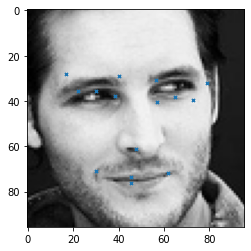

In [ ]:
# loading data and checking it

X, y = load()
plot_sample(X[125],y[120])

In [ ]:
# Split data training ke validation and testing datasets.

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)

# Make sure images have shape (28, 28, 1) - Keras requirement!
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_valid = np.expand_dims(x_valid, -1)

print(x_train.shape)

(1498, 96, 96, 1)


In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Predefined parameters
input_shape = (96, 96, 1)
output_shape = 30

# model = keras.Sequential(
#     [
#         keras.Input(shape=input_shape),
#         layers.Conv2D(256, kernel_size=(5, 5), activation="relu", padding="same"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Flatten(),
#         layers.Dense(output_shape, activation="sigmoid"),
#     ]
# )


# model = keras.Sequential([
#         keras.Input(shape=input_shape),
#         layers.Conv2D(100, kernel_size = (5, 5), activation='relu',  padding="same"),
#         layers.MaxPooling2D(pool_size = (2, 2)),
#         layers.Conv2D(64, kernel_size = (3, 3), activation='relu',  padding="same"),
#         layers.MaxPooling2D(pool_size = (2, 2)),
#         layers.Conv2D(64, kernel_size = (3, 3), activation='relu',  padding="same"),
#         layers.Flatten(),
#         layers.Dense(output_shape, activation="linear"),
#         ])

model = keras.Sequential()
model.add(layers.Conv2D(128, (5, 5), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(output_shape, activation="linear"))




model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 92, 92, 128)       3328      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 46, 46, 128)      0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 46, 46, 128)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 42, 42, 64)        204864    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 21, 21, 64)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 21, 21, 64)       

In [ ]:
from keras.optimizers import SGD

batch_size = 128
epochs = 100

from keras import backend as K
# /import tensor as tf

mse = tf.keras.losses.MeanSquaredError()

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

tf.keras.optimizers.Nadam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam",
)

model.compile(loss=root_mean_squared_error, optimizer="Adam") 
                                       

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/100
11/11 [==============================] - 2s 153ms/step - loss: 0.2047 - val_loss: 0.2376
Epoch 2/100
11/11 [==============================] - 1s 110ms/step - loss: 0.1008 - val_loss: 0.2025
Epoch 3/100
11/11 [==============================] - 1s 108ms/step - loss: 0.0818 - val_loss: 0.1511
Epoch 4/100
11/11 [==============================] - 1s 108ms/step - loss: 0.0749 - val_loss: 0.1267
Epoch 5/100
11/11 [==============================] - 1s 108ms/step - loss: 0.0715 - val_loss: 0.1037
Epoch 6/100
11/11 [==============================] - 1s 111ms/step - loss: 0.0697 - val_loss: 0.0951
Epoch 7/100
11/11 [==============================] - 1s 109ms/step - loss: 0.0688 - val_loss: 0.0861
Epoch 8/100
11/11 [==============================] - 1s 108ms/step - loss: 0.0686 - val_loss: 0.0833
Epoch 9/100
11/11 [==============================] - 1s 111ms/step - loss: 0.0680 - val_loss: 0.0748
Epoch 10/100
11/11 [==============================] - 1s 108ms/step - loss: 0.0681 - val_lo

In [ ]:
y_new = model.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

11/11 [==============================] - 1s 15ms/step
Mean pixel error:  1.4891924


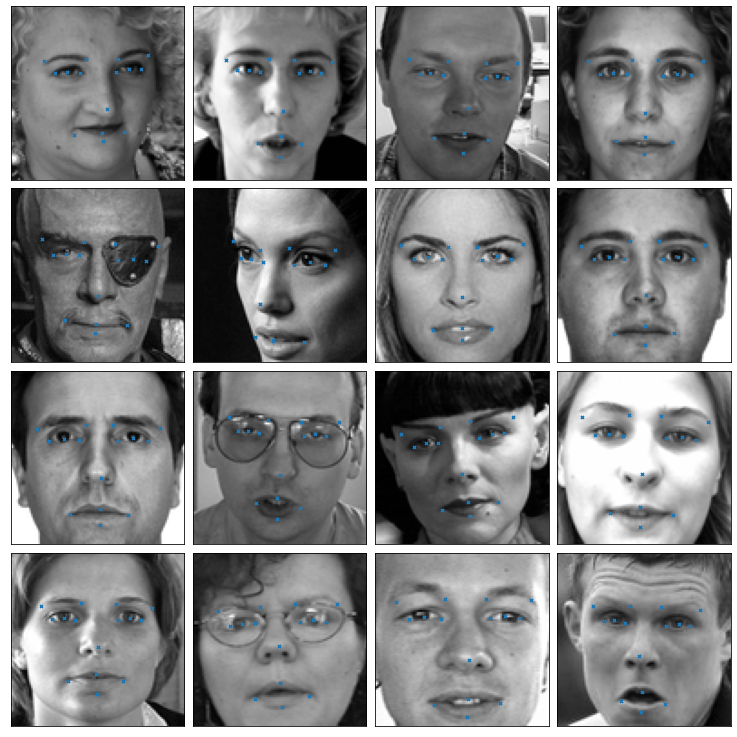

In [ ]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_new[i])
pyplot.show()

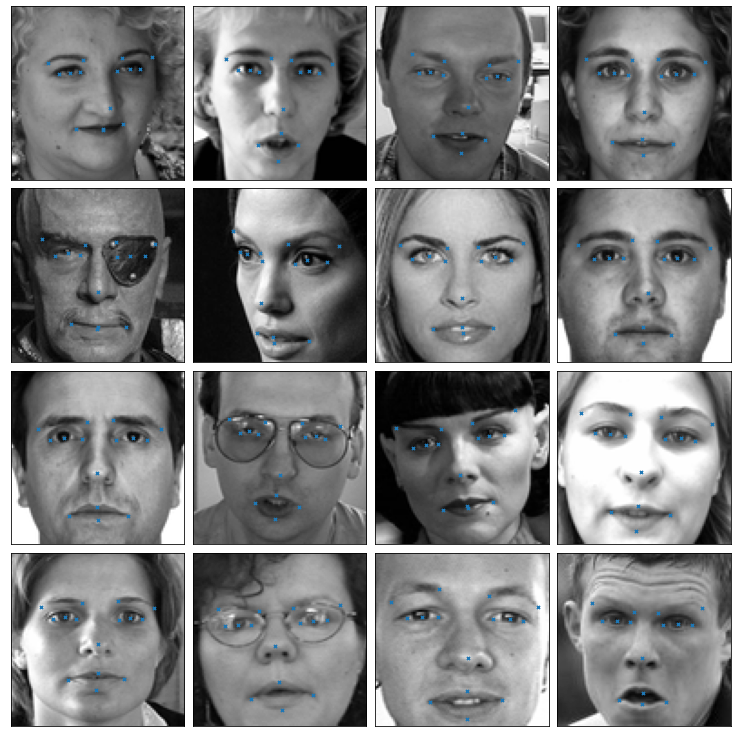

In [ ]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_valid[i])

pyplot.show()

# Reporting

Copy notebook ini dan anda bisa memodifikasi model yang digunakan langsung di notebook ini. Laporan dilakukan di cell ini dengan menjawab pertanyaan berikut.

## Hasil ?  

> Kinerja dari model yang dievaluasi dinyatakan dengan menggunakan ukuran **mean error** dalam satuan pixel. Nilai yang diperoleh saat ini adalah: 1.9823995, anda harus berusaha memperoleh nilai yang lebih baik. Nilai dibawah 1.5 bisa dianggap sangat bagus. Sedangkan 1.4 atau kurang adalah hasil yang *outstanding*!

**Answer**: The mean pixel error is **1.4891924**
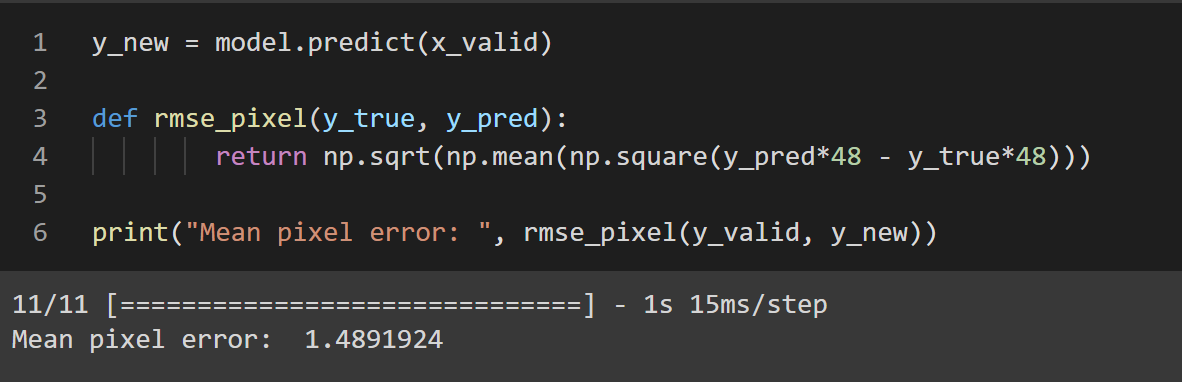

## Arsitektur 

>Jenis network apa yang anda gunakan ? Teknik tambahan apa yang diaplikasikan ?Deskripsikan keduanya dan masing-masing perannya dalam hasil yang anda peroleh.

**Answer**: 
Jenis Network yang digunakan adalah Convolutional Neural  Network dengan arsitektur yang dibuat sendiri dimana disetiap layer convolusinya di kalikan dengan kernel atau filter 5x5 dan 3x3 serta maxpooling layernya menggunakan ukuran 2x2. Untuk ukuran unitnya di buat berbeda pada setiap layer yaitu 128, 64 dan 32. Selain itu untuk mengatasi model yang terlalu overfitting maka saya menambahkan fitur dropout pada masing-masing layernya sebesar 40%. Dropout merupakan teknik regularisasi jaringan syaraf dimana beberapa neuron akan dipilih secara acak dan tidak dipakai selama pelatihan. Dropout mengacu kepada menghilangkan neuron yang berupa hidden mapun layer yang visible di dalam jaringan.

Fungsi aktivasi yang digunakan adalah relu dan linear, fungsi lossnya adalah root_mean_squared_error dan otimizer yang yang digunakan adalah Adam.







Arsitektur yang digunakan:

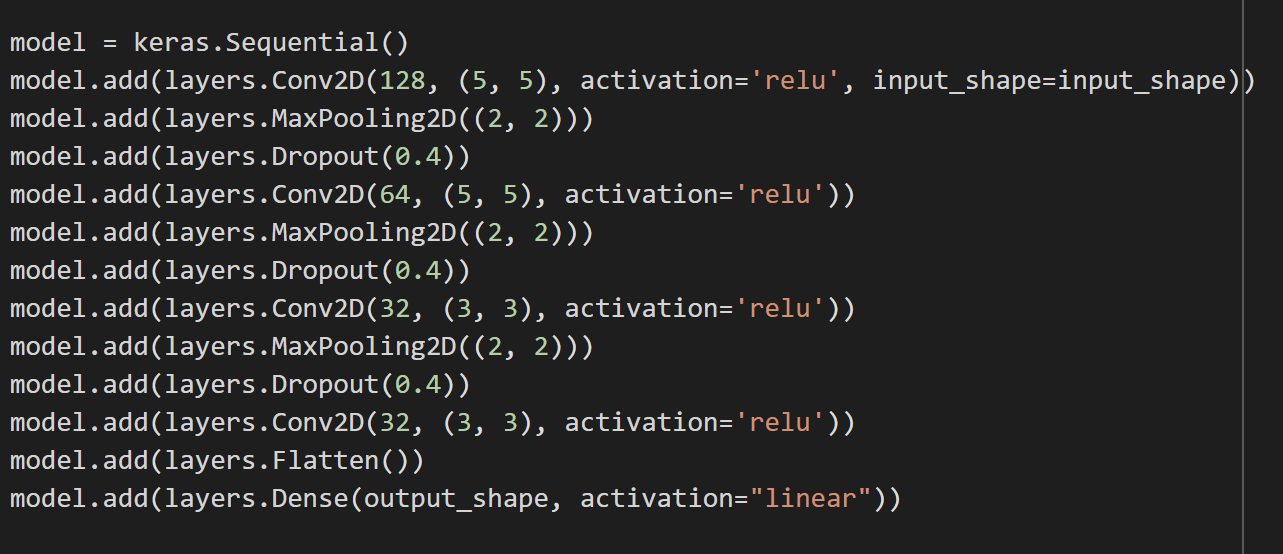